# Neural Network Benchmark Preparations

## Author: Alexander Goudemond, Student Number: 219030365

Previous Summary:

- The author has 10 datasets. Each dataset comes with 2 folders of information: a collection of training data, and a collection of test data. The test data is indicated in the original folder with a (1) in the filename

- The author has prepared the data for training offline, by copying the masks and the corresponding input images into dedicated folders. All of these folders come from the training data folder (NOT the folders containing a (1) in them) This is primarily because the folders with a (1) in them do not contain masks


A summary of the Dataset dimensions for the training data can be found here (explored in notebook 014):

| Dataset name      | Dimensions    | Notes                                |
|-------------------|---------------|--------------------------------------|
| BF-C2DL-HSC       | (1010,1010,3) |                                      |
| BF-C2DL-MuSC      | (1036,1070,3) |                                      |
| DIC-C2DH-HeLa     | (512,512,3)   |                                      |
| Fluo-C2DL-Huh7    | (1024,1024,3) |                                      |
| Fluo-C2DL-MSC\01  | (832,992,3)   | Notice the 2 folders in this dataset |
| Fluo-C2DL-MSC\02  | (782,1200,3)  | Notice the 2 folders in this dataset |
| Fluo-N2DH-SIM+\01 | (690,628,3)   | Notice the 2 folders in this dataset |
| Fluo-N2DH-SIM+\02 | (773,739,3)   | Notice the 2 folders in this dataset |
| Fluo-N2DH-GOWT1   | (1024,1024,3) |                                      |
| Fluo-N2DL-HeLa    | (700,1100,3)  |                                      |
| PhC-C2DH-U373     | (520,696,3)   |                                      |
| PhC-C2DL-PSC      | (576,720,3)   |                                      |

It is worth noting that the images in each individual dataset have consistent dimensions. So the masks for those images also have the same dimensions

In this notebook, the author is going to load images from the RAW Training set (st and ST) and identify benchmarks. 

The goal is to investigate the best performing UNet model for both datasets, in 2 ways:

- A benchmark for 3 different input sizes on the cumulative datasets: (128, 256, 512). 512 is the largest I can go, as that corresponds to the smallest image dimensions present in my dataset (DIC-C2DH-HeLa). The author will investigate what the largest quantity of training images Google Colab can handle is, and use that to guide the patchify step

- On the best performing model, an comparison on training all the datasets together, or on training specific datasets combined together, based on dataset properties. Some possible dataset combinations could be:

    - BF-C2DL-HSC and BF-C2DL-MuSC (Contains a visible "Petri Dish")

    - DIC-C2DH-HeLa and PhC-C2DH-U373 (Abnormal cell shapes and movements)

    - Fluo-C2DL-Huh7 and Fluo-C2DL-MSC (Mixture of cells, cell movement, cell shape)

    - Fluo-N2DH-GOWT1, Fluo-N2DH-SIM+, and Fluo-N2DL-HeLa (Circular cells)

    - PhC-C2DL-PSC (Small packed cells, harsh light)

- for all 8 of the proposed models above, the author will patchify the images. The author will also need to do this for both the st and ST datasets, so 16 models may be trained

- It is worth noting that because Google Colab is being used, the author needs to be clever with regards to how the variables and models are being used. 1 such investigation is the quantity of variables and the quantity of images present before training. Here are some proposed ideas to combat the restrictions of the Free Tier of Google Colab:

    - 6 text files should be generated and saved in the same directory as the Neural Network notebooks. Each text file will contain paths to the training data. This will allow the notebook to open and read a text file, and then load images from that context. This may speed up the process of training several models on different notebooks quickly, as all the notebooks need to do is read a text file

    - The author needs to read in the image paths, and decide on how many paths to use when 'Patchify-ing' the images. One such calculation can be done using the largest image dimensions: (1036,1070), with the cropped image of (1036, 1036) being easier to approach. The possible quantities of images are summarised in the table here:

(X is training, Y is test)

|   | Proposed Number of Images | Patch Size | Quantity of Patchified Images per Image |Resulting Training Data Quantity | Target Quantity |
|---|---------------------------|------------|----------------------------|---------------------------------|--------|
| A | x = 6, y = 1, total = 7 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 384, y = 64, total = 448 | 500 |
| A | x = 25, y = 6, total = 31 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 400, y = 96, total = 496 | 500 |
| A | x = 100, y = 25, total = 125 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 400, y = 100, total = 500 | 500 |
| B | x = 12, y = 3, total = 15 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 768, y = 192, total = 960 | 1000 |
| B | x = 50, y = 12, total = 62 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 800, y = 192, total = 992 | 1000 |
| B | x = 200, y = 50, total = 250 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 800, y = 200, total = 1000 | 1000 |

From the above, a trend forms. If we desire 1500 images, we can write that as (3 * A), and we choose the row with the corresponding patch size

For the above proposed Training Image quantities, it is worth noting that shuffling the data may result in the average image having smaller dimensions - meaning the target quantity may never be reached.

Nonetheless, it is a good target to aim for, to try identify the limits of Google Colab as well

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from os import getcwd
google_drive_path = "/drive/MyDrive"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/"

Please ensure the following folders containg images exist:

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Processed_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Raw_Training_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_128_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_256_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_512_ST

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_GT

drive > MyDrive > COMP700_Images > COMP700_Patchify_Images_Processed_Images_ST

------------------------------------------------------

Then, please ensure a seperate folder with the notebooks and text files exists:

drive > MyDrive > COMP700_Neural_Network_Code

------------------------------------------------------

The first 4 image folders were generated offline by the other notebooks and then uploaded to Google Drive, whereas the next 6 were generated by the notebook 011. The final 2 were generated by 015

## Installs

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [ ]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

from patchify import patchify

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda
from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import clear_output


# Useful functions

In [ ]:
from shutil import move

# save to current location, then move to desired location
def saveImages(array, folder, filename):
    count = 0
    temp = ""
    zeroes = "0"
    for image in array:
        count += 1
        temp = str(count)
        zeroes = "0" * (4 - len(temp))
        path = getcwd() + "/" + filename + "_" + zeroes + temp + ".png"
        image = np.clip(image, 0.0, 1.0) # just incase Matplotlib complains
        
        # print(path)

        plt.imsave(path, image)
        x = cv2.imread(path)
        cv2.imwrite(path, x)
    
    print("Images saved successfuly")
    moveImages(filename, folder, count)
###

def moveImages(filename, folder, numFiles):
    count = 0
    temp = ""
    zeroes = "0"
    taskComplete = False
    for root, dirs, files in walk(getcwd()):
        if (not taskComplete):
            for someFile in files:
                if (filename in someFile):
                    # print("Found ya")
                    count += 1
                    move(someFile, folder + "/" + someFile)

                    if (count >= numFiles):
                      taskComplete = True
                      break
    print("Images moved successfully")
###

In [ ]:
def getImagePaths(path):
    image_paths = []
    for root, dirs, files in walk(path):
        if (len(files) != 0):
          # print(len(files))
          image_paths.append( root )

    image_paths.sort()

    return image_paths
###

def writeArrayToFile(filename, array):
    with open(filename, 'w') as f:
        for row in array:
            f.write(row + "\n")
###

def generateTxtDoc(training_data_folder, filename):
    if (not exists(filename)):
        image_paths = getImagePaths(training_data_directory + training_data_folder)

        writeArrayToFile(filename, image_paths)
        
        if (exists(filename)):
            print("File created successfully")
        else:
            print("Unable to create file...")
    else:
        print("File already Exists")
###

In [ ]:
# returns tuple
def extractDirectoryPaths(path):
    x_directory_locations, y_directory_locations = [], []
    temp = ""

    with open(path) as f:
        lines = f.readlines()
        for item in lines:
            temp = item[ : -1] # remove newline char at end
            if ("X" in temp):
                x_directory_locations.append( temp ) 
            else:
                y_directory_locations.append( temp ) 

    return (x_directory_locations, y_directory_locations)
###

def loadImagePathsFromArray(array):
    image_paths = []

    for path in array:
        for root, dirs, files in walk(path):
            if (len(files) != 0):
                for item in files:
                    image_paths.append(root + "/" + item)

    image_paths.sort()

    return image_paths
###

In [ ]:
def patchifyImages(array, patch_size, imageIsMask, isColourImage=True):
    scaler = MinMaxScaler()
    image_dataset, label_dataset = [], []
    count, appendix = 0, 0
    length = len(array)

    for img_path in array:
        count += 1

        if (imageIsMask):
            image = plt.imread(img_path)
            plt.imsave("temp.png", image, cmap='gray')
            image = cv2.imread("temp.png")
        else:
            image = cv2.imread(img_path)

        #Nearest size divisible by our patch size
        SIZE_X = (image.shape[1] // patch_size) * patch_size 
        SIZE_Y = (image.shape[0] // patch_size) * patch_size 

        image = fromarray(image)
        # Crop entire image into desirable shape
        image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
        image = np.array(image)

        if (count % 50 == 0 or count == 1):
          print("Patchifying ", count, "/", length, " images", sep="")

        #Extract patches from each image
        if (isColourImage):
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        else:
            patches_img = patchify(image, (patch_size, patch_size), step=patch_size) # grayscale patchify
        
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i,j,:,:]
                
                #Use minmaxscaler instead of just dividing by 255. 
                single_patch_img = scaler.fit_transform(
                    single_patch_img.reshape(-1, single_patch_img.shape[-1])
                ).reshape( single_patch_img.shape )
                
                #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                #Drop the extra unecessary dimension that patchify adds. 
                single_patch_img = single_patch_img[0] 

                # scale up values - don't do this for the NN!
                # img_new = (single_patch_img * 255).astype(int) 
                img_new = single_patch_img

                image_dataset.append(img_new)

                # extract folder path, remove extension, and add a counter
                label_dataset.append( extractRhsString(img_path, "T/")[ : -4] + "_" + str(appendix) )
                appendix += 1

        appendix = 0 # reset

    print("Patchify process complete!")

    if (exists("temp.png")):
        remove("temp.png")

    return image_dataset, label_dataset
###

In [ ]:
from tensorflow import keras
from keras.utils import array_to_img

def display(display_list, title=[], figsize=(15, 15)):
    plt.figure(figsize=figsize)

    # update if title not provided
    if (len(title) == 0):
      title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i], wrap=True)
        
        # handle 2D and 3D images
        if (len(display_list[i].shape) == 3 ):
            plt.imshow( array_to_img(display_list[i]), cmap="gray")
        else:
            plt.imshow( display_list[i], cmap="gray")
            
        plt.axis('off')
    plt.tight_layout() # prevents overlap
    plt.show()
###


In [ ]:
# create directories for work we create
def tryMakeDirectories(current_directory, myList):
    path = ""
    for item in myList:
        # initialize
        if (path == ""):
            path = item
        else:
            path = path + "/" + item
            
        try:
            # join comes from os.path
            mkdir( join(current_directory, path) )
        except FileExistsError:
            # print("Folder already exists!")
            pass
        except:
            print("Unknown Error Encountered...")
###

In [ ]:
def extractRhsString(string, symbol):
    index = string.rfind(symbol)
    return string[ index + len(symbol) : ]
###

# Text File Generation

In this section of the notebook, the author will traverse the images loaded on Google Drive, and generate text files for the models to use. The text files will then be saved in the same destination as the Neural Network notebooks

In [ ]:
from os import getcwd, walk
from os.path import exists

In [ ]:
getcwd()

'/content'

In [ ]:
google_drive_path = "/drive/MyDrive"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/"

In [ ]:
training_data_directory

'/content/drive/MyDrive/COMP700_Images/'

Let's do a sanity check before continuing, to ensure our images are consistent:

In [ ]:
# "COMP700_Raw_Training_GT"
training_data_folder = "COMP700_Raw_Training_ST"

st_x_dirs = []
st_y_dirs = []
st_x_length = []
st_y_length = []

for root, dirs, files in walk(training_data_directory + training_data_folder):
    # print(dirs)
    if ("X" in dirs or "Y" in dirs):
        # print("yes", root)
        for root2, dirs2, files2 in walk(root + "/X"):
            st_x_dirs.append( extractRhsString(root2, "ST/") )
            st_x_length.append(len(files2))

        for root2, dirs2, files2 in walk(root + "/Y"):
            st_y_dirs.append( extractRhsString(root2, "ST/") )
            st_y_length.append(len(files2))

In [ ]:
print(st_x_length)
print(st_y_length)
print()
#uncomment if sizes dont match, and find problem dataset
# print(st_x_dirs)
# print(st_y_dirs)


[48, 48, 115, 115, 92, 92, 1764, 1764, 92, 92, 300, 300, 84, 84, 1376, 1376]
[48, 48, 115, 115, 92, 92, 1764, 1764, 92, 92, 300, 300, 84, 84, 1376, 1376]



In [ ]:
# "COMP700_Raw_Training_GT"
training_data_folder = "COMP700_Raw_Training_GT"

gt_x_dirs = []
gt_y_dirs = []
gt_x_length = []
gt_y_length = []

for root, dirs, files in walk(training_data_directory + training_data_folder):
    # print(dirs)
    if ("X" in dirs or "Y" in dirs):
        # print("yes", root)
        for root2, dirs2, files2 in walk(root + "/X"):
            gt_x_dirs.append( extractRhsString(root2, "GT/") )
            gt_x_length.append(len(files2))

        for root2, dirs2, files2 in walk(root + "/Y"):
            gt_y_dirs.append( extractRhsString(root2, "GT/") )
            gt_y_length.append(len(files2))


In [ ]:
print(gt_x_length)
print(gt_y_length)
print()
#uncomment if sizes dont match, and find problem dataset
# print(gt_x_dirs)
# print(gt_y_dirs)


[33, 18, 15, 19, 8, 5, 30, 20, 9, 9, 49, 8, 2, 2, 150, 65, 50, 50, 8, 28]
[33, 18, 15, 19, 8, 5, 30, 20, 9, 9, 49, 8, 2, 2, 150, 65, 50, 50, 8, 28]



Next, we can read the images into our variables, then save them into a text file

In [ ]:
save_location = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"

In [ ]:
# COMP700_Raw_Training_GT text file
training_data_folder = "COMP700_Raw_Training_GT"
filename = save_location + "raw_training_paths_gt.txt"

generateTxtDoc(training_data_folder, filename)

File already Exists


In [ ]:
# COMP700_Raw_Training_ST text file
training_data_folder = "COMP700_Raw_Training_ST"
filename = save_location + "raw_training_paths_st.txt"

generateTxtDoc(training_data_folder, filename)

File already Exists


Next, let us do the same for the Processed dataset

In [ ]:
# COMP700_Raw_Training_GT text file
training_data_folder = "COMP700_Processed_Training_GT"
filename = save_location + "processed_training_paths_gt.txt"

generateTxtDoc(training_data_folder, filename)

File already Exists


In [ ]:
# COMP700_Raw_Training_ST text file
training_data_folder = "COMP700_Processed_Training_ST"
filename = save_location + "processed_training_paths_st.txt"

generateTxtDoc(training_data_folder, filename)

File already Exists


Great! We can now restart the runtime and only run the next sections of the notebook that we need to

# Loading GT Training Data

Here, we can read in the contents of our desired text files and prepare them to be shuffled

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from os import getcwd, walk

In [ ]:
google_drive_path = "/drive/MyDrive"
text_file_location = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"

Extract and load Image

In [ ]:
filename = "raw_training_paths_gt.txt"
gt_x_image_paths, gt_y_image_paths = extractDirectoryPaths(text_file_location + filename)

gt_x_images = loadImagePathsFromArray(gt_x_image_paths)
gt_y_images = loadImagePathsFromArray(gt_y_image_paths)

if (len(gt_x_images) == len(gt_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [ ]:
filename = "raw_training_paths_st.txt"
st_x_image_paths, st_y_image_paths = extractDirectoryPaths(text_file_location + filename)

st_x_images = loadImagePathsFromArray(st_x_image_paths)
st_y_images = loadImagePathsFromArray(st_y_image_paths)

if (len(st_x_images) == len(st_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [ ]:
print("There are", len(st_x_images), "ST images and", len(gt_x_images), "GT images")

There are 7742 ST images and 578 GT images


Because there are 578 total images in the GT dataset, we can try use that dataset first and investigate what input size our model will work for

# Crop and Patchify GT images

Now, we need to go through each of the images in x_image_paths and patchify them

## 128 Patch Size

In [ ]:
scaler = MinMaxScaler()

Recall the table we calculated at the beginning:

(X is training, Y is test)

|   | Proposed Number of Images | Patch Size | Quantity of Patchified Images per Image |Resulting Training Data Quantity | Target Quantity |
|---|---------------------------|------------|----------------------------|---------------------------------|--------|
| A | x = 6, y = 1, total = 7 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 384, y = 64, total = 448 | 500 |
| A | x = 25, y = 6, total = 31 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 400, y = 96, total = 496 | 500 |
| A | x = 100, y = 25, total = 125 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 400, y = 100, total = 500 | 500 |
| B | x = 12, y = 3, total = 15 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 768, y = 192, total = 960 | 1000 |
| B | x = 50, y = 12, total = 62 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 800, y = 192, total = 992 | 1000 |
| B | x = 200, y = 50, total = 250 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 800, y = 200, total = 1000 | 1000 |

From the above, a trend forms. If we desire 1500 images, we can write that as (3 * A), and we choose the row with the corresponding patch size

So, let's say we want to end up with 1000 images of Patchified images, and a patch size of 128.

We need 12 X images and 3 Y images.

But that is far too narrow for our dataset... It would mean we would be looking at 6 possible datasets only...

Instead, let's generate 10000 images, randomly shuffle them, and select the first 1000 for training!

To get ~10000 images, we can use a ratio of 20. So X = 12 * 20 = 240, Y = 6 * 20 = 120. To verify this, 240 * 64 = 15360 (as a highest peak) On average, it will be closer to 10000.

 We can shuffle the images using ScikitLearn, and then select only part of the cluster for future use



In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, _, y_train, _ = train_test_split(
    gt_x_images, gt_y_images, test_size=0.33, random_state=42
)

In [ ]:
# verify data corresponds:
for i in range(5):
  print( extractRhsString(x_train[i], "/t"), ":::", extractRhsString(y_train[i], "/man_seg") )

1088.tif ::: 1088.tif
078.tif ::: 078.tif
0347.tif ::: 0347.tif
026.tif ::: 026.tif
0838.tif ::: 0838.tif


Verify All images correspond:

In [ ]:
count = 0
for i in range(len(x_train)):
    if ( extractRhsString(x_train[i], "/t") != extractRhsString(y_train[i], "/man_seg") ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


Now! The problem we seem to be running into is that patchifying large quantities of images is not working... So, let us do this in batches. We desire 240 images to be processed

In [ ]:
patch_size = 128
gt_x_patchify_images, gt_x_patchify_labels = patchifyImages(x_train[0 : 240], patch_size, imageIsMask=False)

print()
print(len(gt_x_patchify_images), "images exist")

Patchifying 1/240 images
Patchifying 50/240 images
Patchifying 100/240 images
Patchifying 150/240 images
Patchifying 200/240 images
Patchify process complete!

9530 images exist


In [ ]:
patch_size = 128
gt_y_patchify_images, gt_y_patchify_labels = patchifyImages(y_train[0 : 240], patch_size, imageIsMask=True)

print()
print(len(gt_y_patchify_images), "images exist")

Patchifying 1/240 images
Patchifying 50/240 images
Patchifying 100/240 images
Patchifying 150/240 images
Patchifying 200/240 images
Patchify process complete!

9530 images exist


Index used: 239
Index used: 942
Index used: 1989


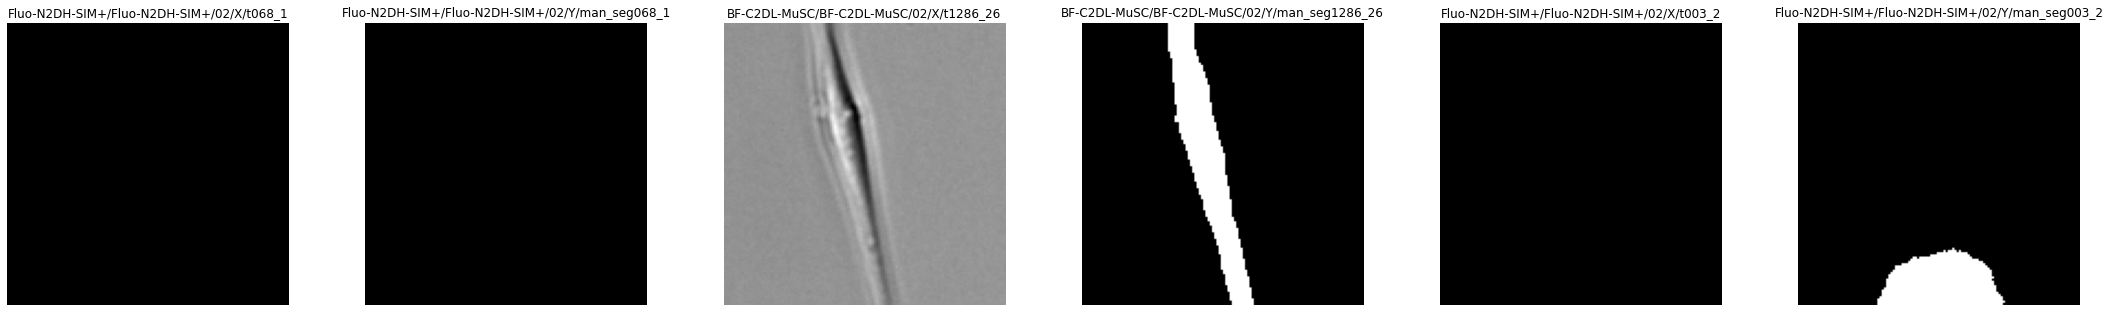

In [ ]:
# verify patches correspond before shuffling:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(gt_x_patchify_images)-1)
    print("Index used:", index)

    array.append( gt_x_patchify_images[index] ) 
    array.append( gt_y_patchify_images[index] )
    labels.append( gt_x_patchify_labels[index] )
    labels.append( gt_y_patchify_labels[index] )

display(array, labels, figsize=(30, 30))

In the above example, index 942 has an interesting mask. Let us and investigate what the original image looked like

In [ ]:
gt_y_patchify_labels[942]

'BF-C2DL-MuSC/BF-C2DL-MuSC/02/Y/man_seg1286_26'

BF-C2DL-MuSC/BF-C2DL-MuSC/02/X/t1286.tif
BF-C2DL-MuSC/BF-C2DL-MuSC/02/Y/man_seg1286.tif


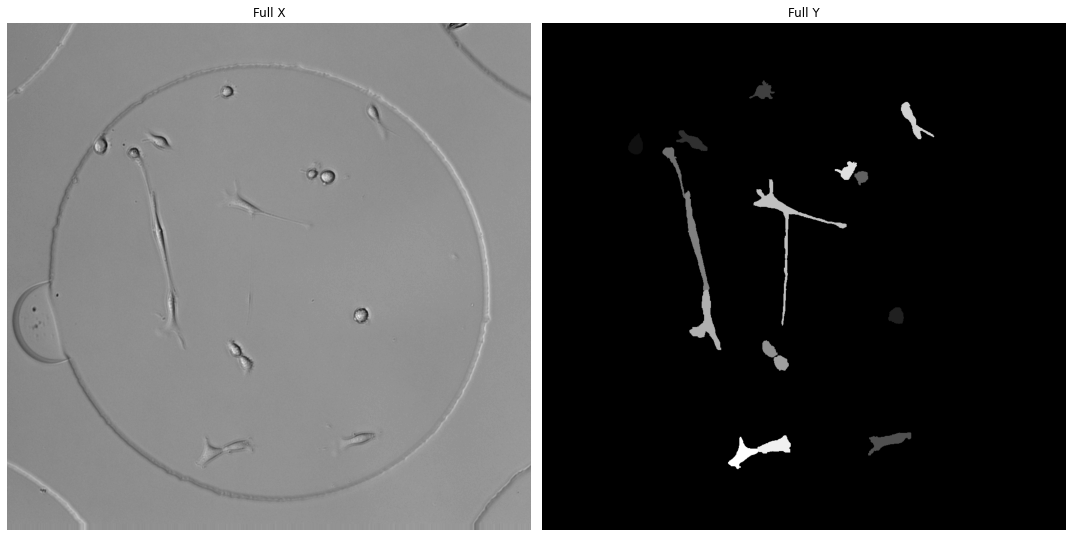

In [ ]:
# remove patchify appendix
index_location = 942
treasure = ( gt_y_patchify_labels[index_location] )[ : -3]

for i in range(len(gt_y_images)):
    if (treasure in gt_y_images[i]):
        print( extractRhsString(gt_x_images[i], "T/") )
        print( extractRhsString(gt_y_images[i], "T/") )
        break

# 'i' now contains the location of the images!

array = [plt.imread(gt_x_images[i]), plt.imread(gt_y_images[i])]
labels = ["Full X", "Full Y"]

display(array, labels)

Another example:

Index used: 7601
Index used: 4756
Index used: 745


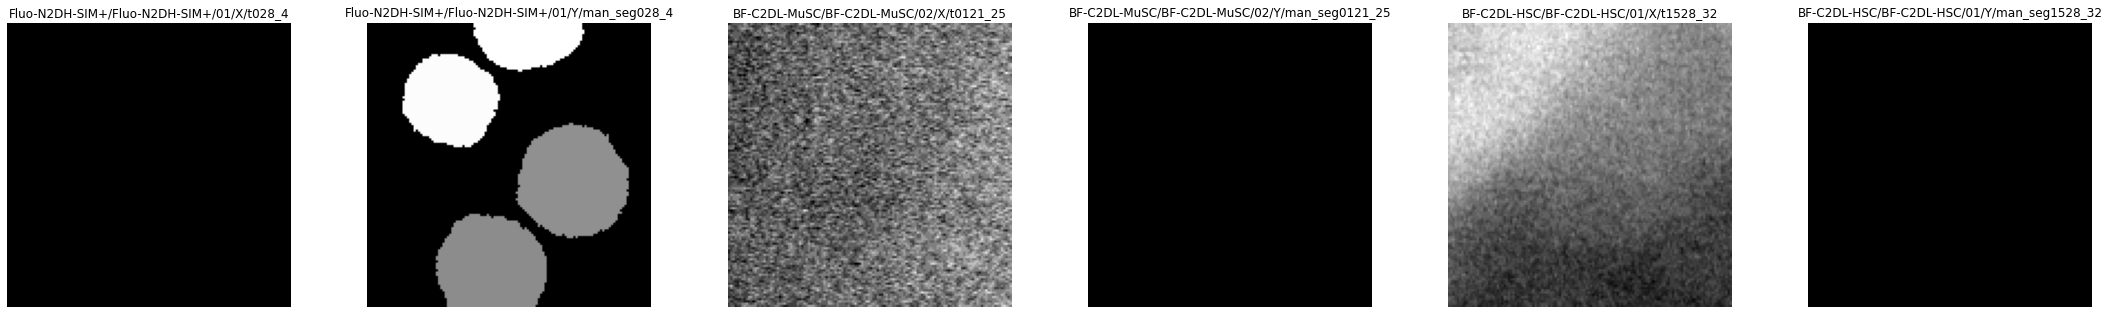

In [ ]:
# verify patches correspond before shuffling:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(gt_x_patchify_images)-1)
    print("Index used:", index)

    array.append( gt_x_patchify_images[index] ) 
    array.append( gt_y_patchify_images[index] )
    labels.append( gt_x_patchify_labels[index] )
    labels.append( gt_y_patchify_labels[index] )

display(array, labels, figsize=(30, 30))

In the above example, index 7601 appears to have inconsistent data... What the original image looked like?

Fluo-N2DH-SIM+/Fluo-N2DH-SIM+/01/X/t028.tif
Fluo-N2DH-SIM+/Fluo-N2DH-SIM+/01/Y/man_seg028.tif


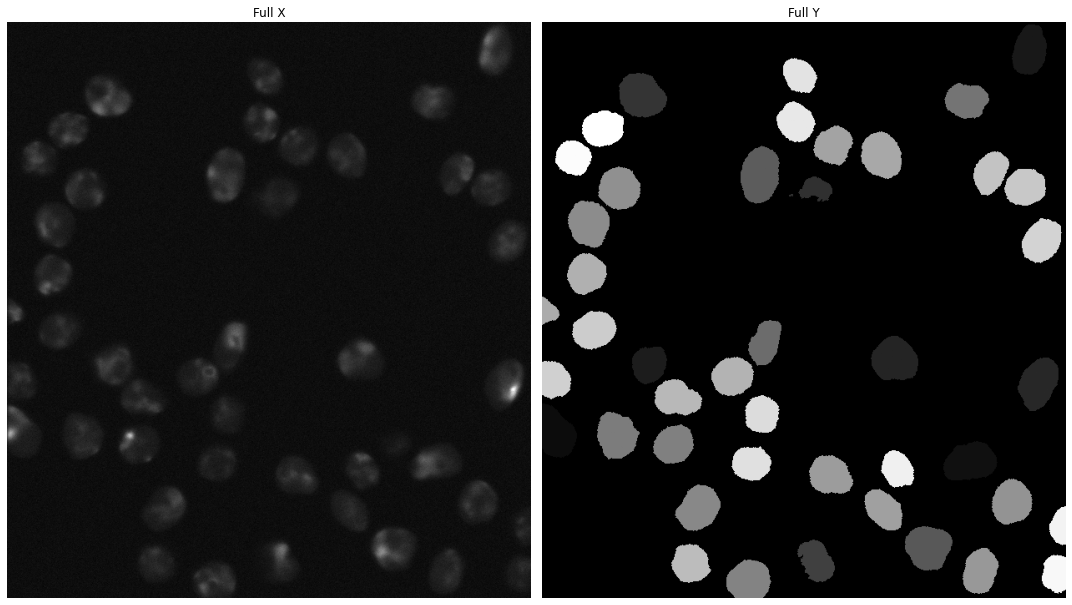

In [ ]:
# remove patchify appendix
index_location = 7601
treasure = ( gt_y_patchify_labels[index_location] )[ : -2]

for i in range(len(gt_y_images)):
    if (treasure in gt_y_images[i]):
        print( extractRhsString(gt_x_images[i], "T/") )
        print( extractRhsString(gt_y_images[i], "T/") )
        break

# 'i' now contains the location of the images!

array = [plt.imread(gt_x_images[i]), plt.imread(gt_y_images[i])]
labels = ["Full X", "Full Y"]

display(array, labels)

Clearly, the model is working! Let us now shuffle and see if the images correspond

We can now reshuffle our data and select the first 800

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, x_test, y_train, y_test = train_test_split(
    gt_x_patchify_images, gt_y_patchify_images, test_size=0.33, random_state=42
)

x_train = x_train[0:800]
x_test = x_test[0:200]
y_train = y_train[0:800]
y_test = y_test[0:200]

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train_labels, x_test_labels, y_train_labels, y_test_labels = train_test_split(
    gt_x_patchify_labels, gt_y_patchify_labels, test_size=0.33, random_state=42
)

x_train_labels = x_train_labels[0:800]
x_test_labels = x_test_labels[0:200]
y_train_labels = y_train_labels[0:800]
y_test_labels = y_test_labels[0:200]

Index used: 183
Index used: 790
Index used: 267


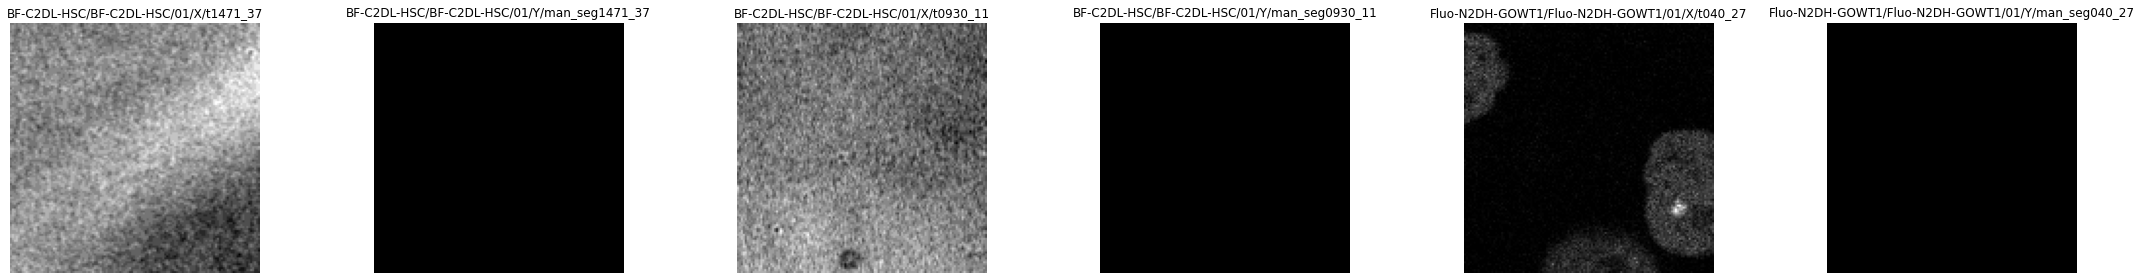

In [ ]:
# verify patches correspond before shuffling:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(x_train)-1)
    print("Index used:", index)

    array.append( x_train[index] ) 
    array.append( y_train[index] )
    labels.append( x_train_labels[index] )
    labels.append( y_train_labels[index] )

display(array, labels, figsize=(30, 30))

Let's investigate 267

Fluo-N2DH-GOWT1/Fluo-N2DH-GOWT1/01/X/t040.tif
Fluo-N2DH-GOWT1/Fluo-N2DH-GOWT1/01/Y/man_seg040.tif


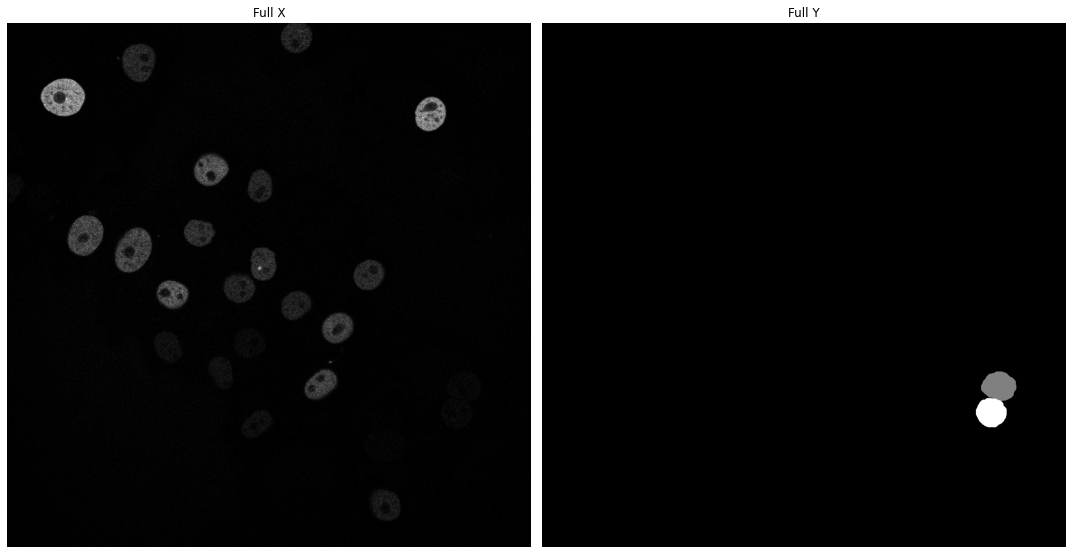

In [ ]:
# remove patchify appendix
index_location = 267
treasure = ( y_train_labels[index_location] )[ : -3]

for i in range(len(gt_y_images)):
    if (treasure in gt_y_images[i]):
        print( extractRhsString(gt_x_images[i], "T/") )
        print( extractRhsString(gt_y_images[i], "T/") )
        break

# 'i' now contains the location of the images!

array = [plt.imread(gt_x_images[i]), plt.imread(gt_y_images[i])]
labels = ["Full X", "Full Y"]

display(array, labels)

## Update Mask Classes from Multiclass to Binary class

In [ ]:
y_train_binary = []

for mask in y_train:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_train_binary.append( temp )

In [ ]:
y_test_binary = []

for mask in y_test:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_test_binary.append( temp )

## Compare a few patches

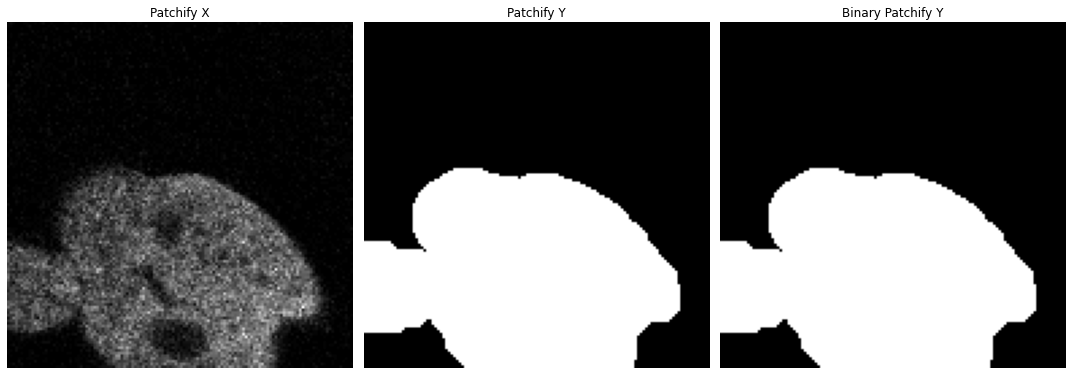

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

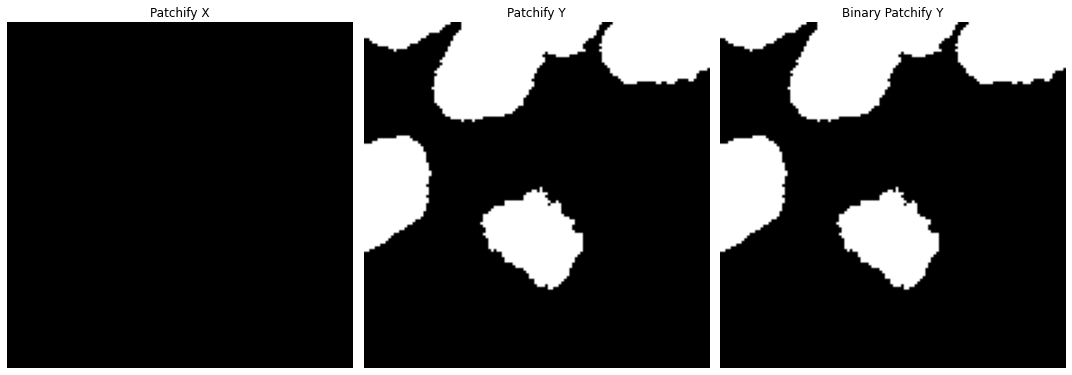

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

## Save Training data for future use

In this section of the notebook, the author will save the images onto Google Drive, such that a future notebook can load the images and use them for training.

This may assist with the RAM Restrictions present on Google Colab, to prevent everything happening in 1 notebook

In [ ]:
directory_list = ["COMP700_Patchify_Images_128_GT", "Training", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_128_GT", "Training", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_128_GT", "Test", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_128_GT", "Test", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

Uncomment and rerun if need be

In [ ]:
# saveImages(x_train, training_data_directory + "COMP700_Patchify_Images_128_GT/Training/X", "training_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_train_binary, training_data_directory + "COMP700_Patchify_Images_128_GT/Training/Y", "training_mask")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(x_test, training_data_directory + "COMP700_Patchify_Images_128_GT/Test/X", "test_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_test_binary, training_data_directory + "COMP700_Patchify_Images_128_GT/Test/Y", "test_mask")

Images saved successfuly
Images moved successfully


## 256 Patch Size

In [ ]:
scaler = MinMaxScaler()

Recall the table we calculated at the beginning:

(X is training, Y is test)

|   | Proposed Number of Images | Patch Size | Quantity of Patchified Images per Image |Resulting Training Data Quantity | Target Quantity |
|---|---------------------------|------------|----------------------------|---------------------------------|--------|
| A | x = 6, y = 1, total = 7 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 384, y = 64, total = 448 | 500 |
| A | x = 25, y = 6, total = 31 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 400, y = 96, total = 496 | 500 |
| A | x = 100, y = 25, total = 125 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 400, y = 100, total = 500 | 500 |
| B | x = 12, y = 3, total = 15 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 768, y = 192, total = 960 | 1000 |
| B | x = 50, y = 12, total = 62 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 800, y = 192, total = 992 | 1000 |
| B | x = 200, y = 50, total = 250 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 800, y = 200, total = 1000 | 1000 |

From the above, a trend forms. If we desire 1500 images, we can write that as (3 * A), and we choose the row with the corresponding patch size

So, let's say we want to end up with 1000 images of Patchified images, and a patch size of 256.

We need 50 X images and 12 Y images.

But that is a bit too narrow for our dataset... It may mean we would be looking exclusively at some datasets and not others...

Instead, let's generate 10000 patchified images, randomly shuffle them, and select the first 1000 for training!

To get this, we can use all the data from our training set. This is because our x_train only contains 387 images to begin with. We could use 800, but that is missing

We can shuffle the images using ScikitLearn, and then select only part of the cluster for future use

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, _, y_train, _ = train_test_split(
    gt_x_images, gt_y_images, test_size=0.33, random_state=42
)

In [ ]:
# verify data corresponds:
for i in range(5):
  print(x_train[i], ":::", y_train[i])

/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-MuSC/BF-C2DL-MuSC/02/X/t1088.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-MuSC/BF-C2DL-MuSC/02/Y/man_seg1088.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/Fluo-N2DL-HeLa/Fluo-N2DL-HeLa/02/X/t078.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/Fluo-N2DL-HeLa/Fluo-N2DL-HeLa/02/Y/man_seg078.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/01/X/t0347.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0347.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/02/X/t026.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/02/Y/man_seg026.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/01/X/t0838.tif ::: /content/drive/MyDrive/COMP

In [ ]:
patch_size = 256
gt_x_patchify_images, gt_x_patchify_labels = patchifyImages(x_train[0 : 480], patch_size, imageIsMask=False)

print()
print(len(gt_x_patchify_images), "images exist")

Patchifying 1/387 images
Patchifying 50/387 images
Patchifying 100/387 images
Patchifying 150/387 images
Patchifying 200/387 images
Patchifying 250/387 images
Patchifying 300/387 images
Patchifying 350/387 images
Patchify process complete!

3466 images exist


In [ ]:
patch_size = 256
gt_y_patchify_images, gt_y_patchify_labels = patchifyImages(y_train[0 : 480], patch_size, imageIsMask=True)

print()
print(len(gt_y_patchify_images), "images exist")

Patchifying 1/387 images
Patchifying 50/387 images
Patchifying 100/387 images
Patchifying 150/387 images
Patchifying 200/387 images
Patchifying 250/387 images
Patchifying 300/387 images
Patchifying 350/387 images
Patchify process complete!

3466 images exist


We can now reshuffle our data and take the first 800

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, x_test, y_train, y_test = train_test_split(
    gt_x_patchify_images, gt_y_patchify_images, test_size=0.33, random_state=42
)

x_train = x_train[0:800]
x_test = x_test[0:200]
y_train = y_train[0:800]
y_test = y_test[0:200]

## Update Mask Classes from Multiclass to Binary class

In [ ]:
y_train_binary = []

for mask in y_train:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_train_binary.append( temp )

In [ ]:
y_test_binary = []

for mask in y_test:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_test_binary.append( temp )

## Compare a few patches

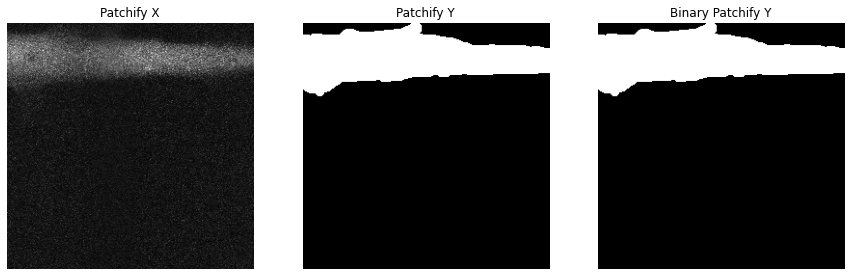

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

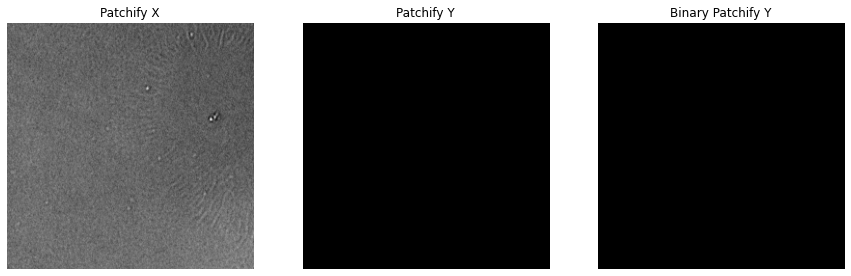

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

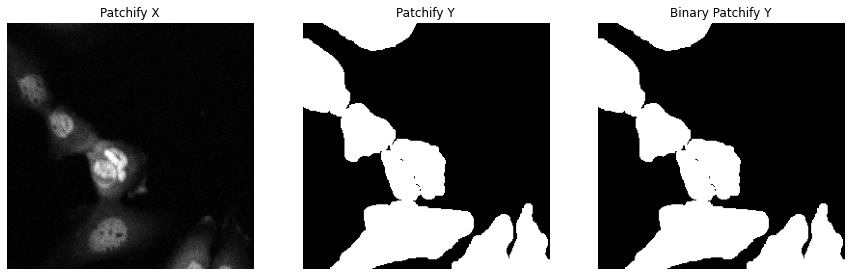

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

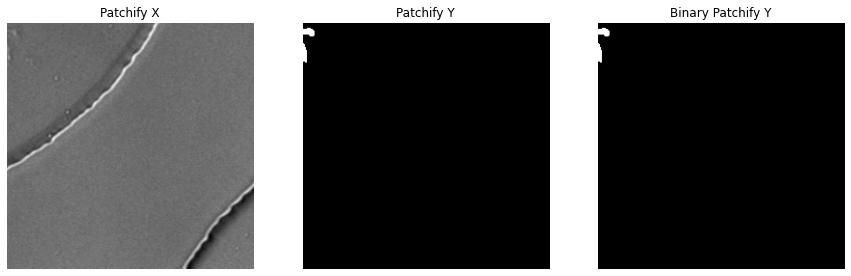

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

## Save Training data for future use

In [ ]:
directory_list = ["COMP700_Patchify_Images_256_GT", "Training", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_256_GT", "Training", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_256_GT", "Test", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_256_GT", "Test", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

In [ ]:
# saveImages(x_train, training_data_directory + "COMP700_Patchify_Images_256_GT/Training/X", "training_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_train_binary, training_data_directory + "COMP700_Patchify_Images_256_GT/Training/Y", "training_mask")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(x_test, training_data_directory + "COMP700_Patchify_Images_256_GT/Test/X", "test_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_test_binary, training_data_directory + "COMP700_Patchify_Images_256_GT/Test/Y", "test_mask")

Images saved successfuly
Images moved successfully


## 512 Patch Size

In [ ]:
scaler = MinMaxScaler()

Recall the table we calculated at the beginning:

(X is training, Y is test)

|   | Proposed Number of Images | Patch Size | Quantity of Patchified Images per Image |Resulting Training Data Quantity | Target Quantity |
|---|---------------------------|------------|----------------------------|---------------------------------|--------|
| A | x = 6, y = 1, total = 7 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 384, y = 64, total = 448 | 500 |
| A | x = 25, y = 6, total = 31 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 400, y = 96, total = 496 | 500 |
| A | x = 100, y = 25, total = 125 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 400, y = 100, total = 500 | 500 |
| B | x = 12, y = 3, total = 15 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 768, y = 192, total = 960 | 1000 |
| B | x = 50, y = 12, total = 62 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 800, y = 192, total = 992 | 1000 |
| B | x = 200, y = 50, total = 250 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 800, y = 200, total = 1000 | 1000 |

From the above, a trend forms. If we desire 1500 images, we can write that as (3 * A), and we choose the row with the corresponding patch size

So, let's say we want to end up with 1000 images of Patchified images, and a patch size of 512.

We need 200 X images and 250 Y images.

But that is a bit too narrow for our dataset... It may mean we would be looking exclusively at some datasets and not others...

Instead, let's generate 10000 patchified images, randomly shuffle them, and select the first 1000 for training!

To get this, we can use all the data from our training set. This is because our x_train only contains 387 images to begin with

We can shuffle the images using ScikitLearn, and then select only part of the cluster for future use

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, _, y_train, _ = train_test_split(
    gt_x_images, gt_y_images, test_size=0.33, random_state=42
)

In [ ]:
# verify data corresponds:
for i in range(5):
  print(x_train[i], ":::", y_train[i])

/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-MuSC/BF-C2DL-MuSC/02/X/t1088.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-MuSC/BF-C2DL-MuSC/02/Y/man_seg1088.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/Fluo-N2DL-HeLa/Fluo-N2DL-HeLa/02/X/t078.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/Fluo-N2DL-HeLa/Fluo-N2DL-HeLa/02/Y/man_seg078.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/01/X/t0347.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0347.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/02/X/t026.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/PhC-C2DH-U373/PhC-C2DH-U373/02/Y/man_seg026.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_GT/BF-C2DL-HSC/BF-C2DL-HSC/01/X/t0838.tif ::: /content/drive/MyDrive/COMP

In [ ]:
def extractRHS(string, char):
  index = string.rfind(char)
  # print(index)
  return string[index + len(char) : ]
###

errors = []
count = 0
for i in range(len(x_train)):
  if (extractRHS(x_train[i], "/t") != extractRHS(y_train[i], "g")):
    count += 1
    errors.append(i)

print(count, "image(s) do not match")

0 image(s) do not match


In [ ]:
patch_size = 512
gt_x_patchify_images, gt_x_patchify_labels = patchifyImages(x_train, patch_size, imageIsMask=False)

print()
print(len(gt_x_patchify_images), "images exist")

Patchifying 1/387 images
Patchifying 50/387 images
Patchifying 100/387 images
Patchifying 150/387 images
Patchifying 200/387 images
Patchifying 250/387 images
Patchifying 300/387 images
Patchifying 350/387 images
Patchify process complete!

728 images exist


In [ ]:
patch_size = 512
gt_y_patchify_images, gt_x_patchify_labels = patchifyImages(y_train, patch_size, imageIsMask=True)

print()
print(len(gt_y_patchify_images), "images exist")

Patchifying 1/387 images
Patchifying 50/387 images
Patchifying 100/387 images
Patchifying 150/387 images
Patchifying 200/387 images
Patchifying 250/387 images
Patchifying 300/387 images
Patchifying 350/387 images
Patchify process complete!

728 images exist


We can now reshuffle our data and take the first 800

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, x_test, y_train, y_test = train_test_split(
    gt_x_patchify_images, gt_y_patchify_images, test_size=0.33, random_state=42
)

x_train = x_train[0:800]
x_test = x_test[0:200]
y_train = y_train[0:800]
y_test = y_test[0:200]

## Update Mask Classes from Multiclass to Binary class

In [ ]:
y_train_binary = []

for mask in y_train:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_train_binary.append( temp )

In [ ]:
y_test_binary = []

for mask in y_test:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_test_binary.append( temp )

## Compare a few patches

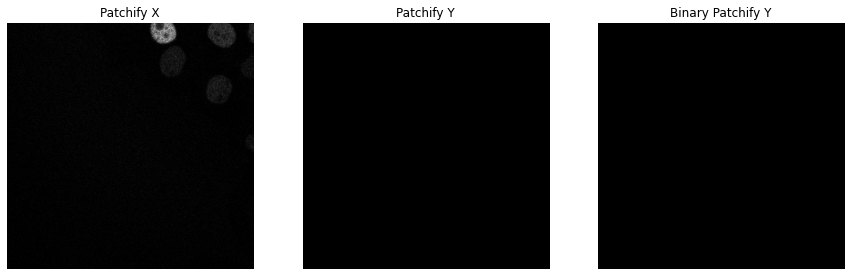

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

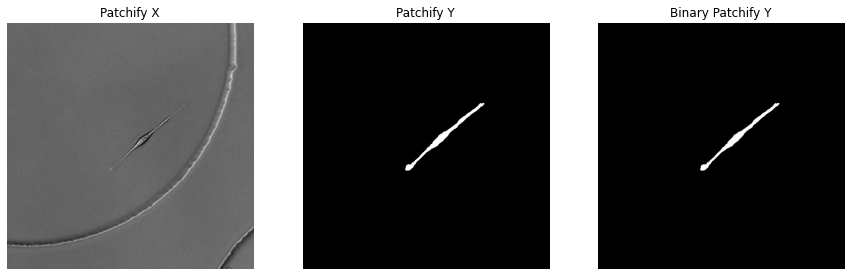

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

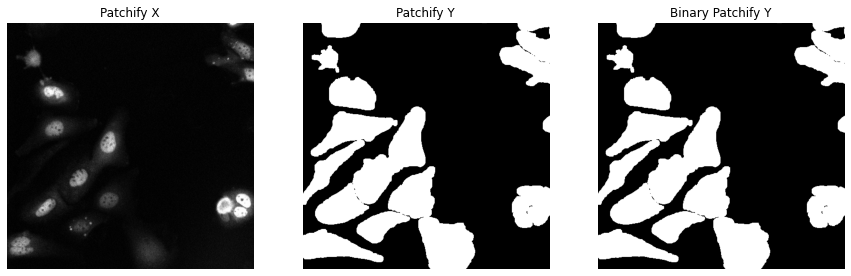

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

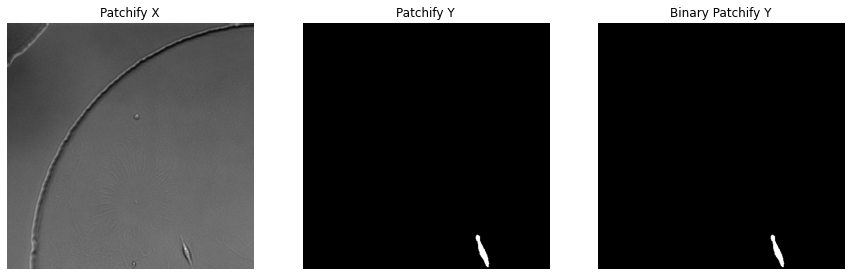

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

## Save Training data for future use

In [ ]:
directory_list = ["COMP700_Patchify_Images_512_GT", "Training", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_512_GT", "Training", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_512_GT", "Test", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_512_GT", "Test", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

In [ ]:
# saveImages(x_train, training_data_directory + "COMP700_Patchify_Images_512_GT/Training/X", "training_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_train_binary, training_data_directory + "COMP700_Patchify_Images_512_GT/Training/Y", "training_mask")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(x_test, training_data_directory + "COMP700_Patchify_Images_512_GT/Test/X", "test_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_test_binary, training_data_directory + "COMP700_Patchify_Images_512_GT/Test/Y", "test_mask")

Images saved successfuly
Images moved successfully


# Loading ST Training Data

Here, we can read in the contents of our desired text files and prepare them to be shuffled

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from os import getcwd, walk

In [ ]:
google_drive_path = "/drive/MyDrive"
text_file_location = getcwd() + google_drive_path + "/COMP700_Neural_Network_Code/"

Extract and load Image

In [ ]:
filename = "raw_training_paths_gt.txt"
gt_x_image_paths, gt_y_image_paths = extractDirectoryPaths(text_file_location + filename)

gt_x_images = loadImagePathsFromArray(gt_x_image_paths)
gt_y_images = loadImagePathsFromArray(gt_y_image_paths)

if (len(gt_x_images) == len(gt_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [ ]:
filename = "raw_training_paths_st.txt"
st_x_image_paths, st_y_image_paths = extractDirectoryPaths(text_file_location + filename)

st_x_images = loadImagePathsFromArray(st_x_image_paths)
st_y_images = loadImagePathsFromArray(st_y_image_paths)

if (len(st_x_images) == len(st_y_images)):
    print("Same quantity of images and masks!")
else:
    print("Not all pictures match...")

Same quantity of images and masks!


In [ ]:
print("There are", len(st_x_images), "ST images and", len(gt_x_images), "GT images")

There are 7742 ST images and 578 GT images


Because there are 578 total images in the GT dataset, we can try use that dataset first and investigate what input size our model will work for

# Crop and Patchify ST images

In this section of the notebook, the same procedure stipulated by the above section will be applied to the ST images

## 128 Patch Size

In [ ]:
scaler = MinMaxScaler()

Recall the table we calculated at the beginning:

(X is training, Y is test)

|   | Proposed Number of Images | Patch Size | Quantity of Patchified Images per Image |Resulting Training Data Quantity | Target Quantity |
|---|---------------------------|------------|----------------------------|---------------------------------|--------|
| A | x = 6, y = 1, total = 7 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 384, y = 64, total = 448 | 500 |
| A | x = 25, y = 6, total = 31 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 400, y = 96, total = 496 | 500 |
| A | x = 100, y = 25, total = 125 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 400, y = 100, total = 500 | 500 |
| B | x = 12, y = 3, total = 15 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 768, y = 192, total = 960 | 1000 |
| B | x = 50, y = 12, total = 62 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 800, y = 192, total = 992 | 1000 |
| B | x = 200, y = 50, total = 250 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 800, y = 200, total = 1000 | 1000 |

From the above, a trend forms. If we desire 1500 images, we can write that as (3 * A), and we choose the row with the corresponding patch size

So, let's say we want to end up with 1000 images of Patchified images, and a patch size of 128.

We need 12 X images and 3 Y images.

But that is far too narrow for our dataset... It would mean we would be looking at 6 possible datasets only...

Instead, let's generate 10000 images, randomly shuffle them, and select the first 1000 for training!

To get ~10000 images, we can use a ratio of 20. So X = 12 * 20 = 240, Y = 6 * 20 = 120. To verify this, 240 * 64 = 15360 (as a highest peak) On average, it will be closer to 10000.

 We can shuffle the images using ScikitLearn, and then select only part of the cluster for future use



In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, _, y_train, _ = train_test_split(
    st_x_images, st_y_images, test_size=0.33, random_state=42
)

In [ ]:
print(len(x_train), ":::", len(y_train))

5187 ::: 5187


In [ ]:
# verify data corresponds:
for i in range(5):
  print( extractRhsString(x_train[i], "/t"), ":::", extractRhsString(y_train[i], "/man_seg") )

0066.tif ::: 0066.tif
0821.tif ::: 0821.tif
0047.tif ::: 0047.tif
0485.tif ::: 0485.tif
1350.tif ::: 1350.tif


Verify All images correspond:

In [ ]:
count = 0
for i in range(len(x_train)):
    if ( extractRhsString(x_train[i], "/t") != extractRhsString(y_train[i], "/man_seg") ):
        count += 1

print(count, "image(s) do not match")

0 image(s) do not match


Now! The problem we seem to be running into is that patchifying large quantities of images is not working... So, let us do this in batches. We desire 240 images to be processed

In [ ]:
patch_size = 128
st_x_patchify_images, st_x_patchify_labels = patchifyImages(x_train[0 : 240], patch_size, imageIsMask=False)

print()
print(len(st_x_patchify_images), "images exist")

Patchifying 1/240 images
Patchifying 50/240 images
Patchifying 100/240 images
Patchifying 150/240 images
Patchifying 200/240 images
Patchify process complete!

12215 images exist


In [ ]:
patch_size = 128
st_y_patchify_images, st_y_patchify_labels = patchifyImages(y_train[0 : 240], patch_size, imageIsMask=True)

print()
print(len(st_y_patchify_images), "images exist")

Patchifying 1/240 images
Patchifying 50/240 images
Patchifying 100/240 images
Patchifying 150/240 images
Patchifying 200/240 images
Patchify process complete!

12215 images exist


Index used: 1816
Index used: 6705
Index used: 9361


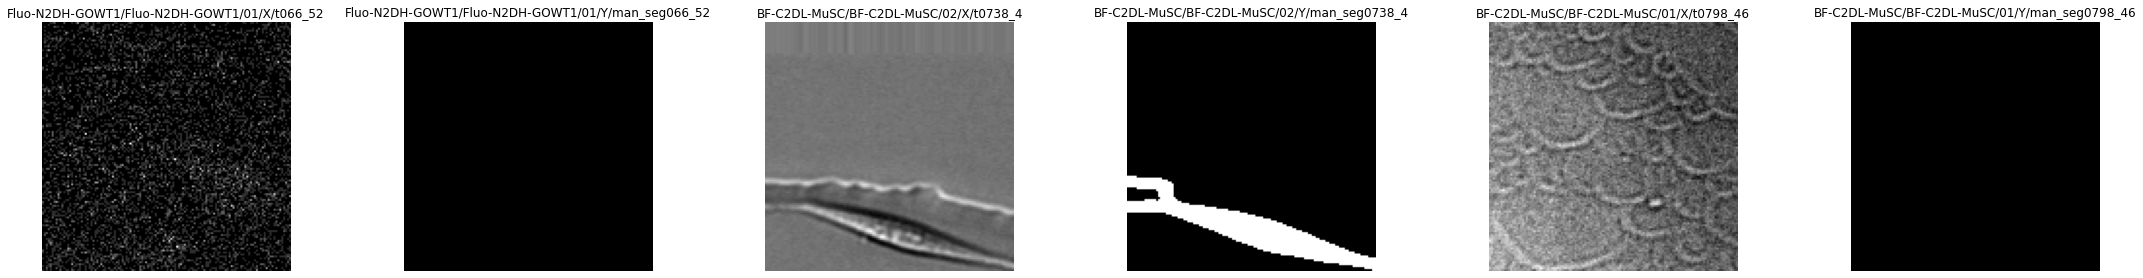

In [ ]:
# verify patches correspond before shuffling:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(st_x_patchify_images)-1)
    print("Index used:", index)

    array.append( st_x_patchify_images[index] ) 
    array.append( st_y_patchify_images[index] )
    labels.append( st_x_patchify_labels[index] )
    labels.append( st_y_patchify_labels[index] )

display(array, labels, figsize=(30, 30))

In the above example, index 6705 has an interesting mask. Let us and investigate what the original image looked like

In [ ]:
st_y_patchify_labels[6705]

'BF-C2DL-MuSC/BF-C2DL-MuSC/02/Y/man_seg0738_4'

BF-C2DL-MuSC/BF-C2DL-MuSC/02/X/t0738.tif
BF-C2DL-MuSC/BF-C2DL-MuSC/02/Y/man_seg0738.tif


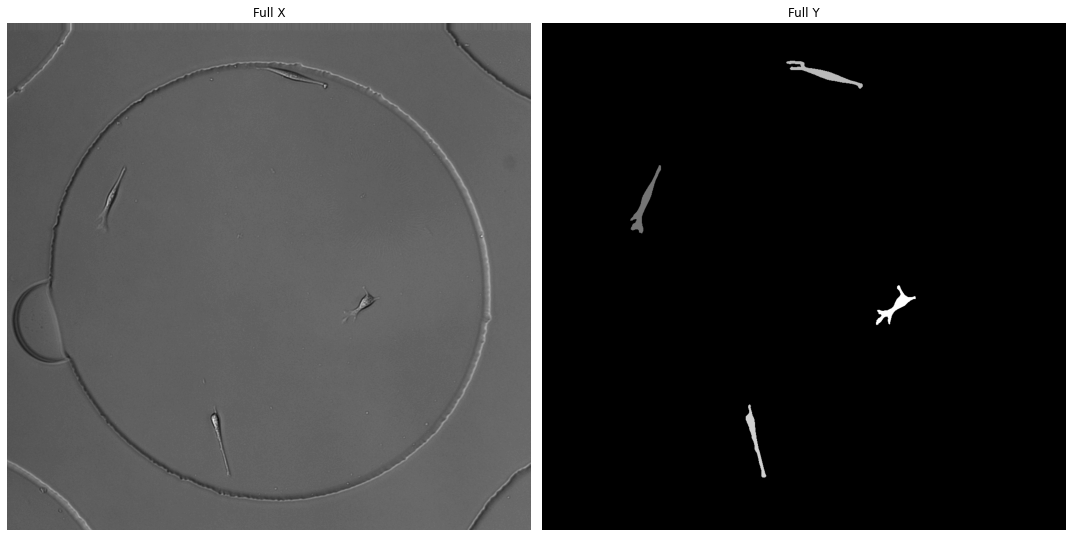

In [ ]:
# remove patchify appendix
index_location = 6705
treasure = ( st_y_patchify_labels[index_location] )[ : -2]

for i in range(len(st_y_images)):
    if (treasure in st_y_images[i]):
        print( extractRhsString(st_x_images[i], "T/") )
        print( extractRhsString(st_y_images[i], "T/") )
        break

# 'i' now contains the location of the images!

array = [plt.imread(st_x_images[i]), plt.imread(st_y_images[i])]
labels = ["Full X", "Full Y"]

display(array, labels)

Another example:

Index used: 5692
Index used: 1350
Index used: 12016


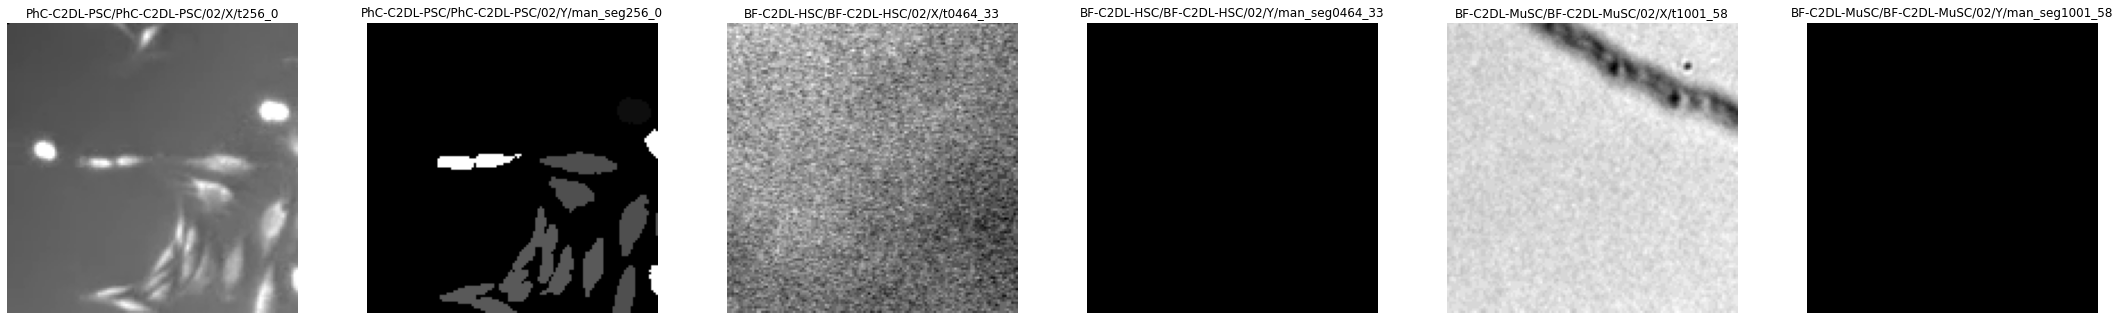

In [ ]:
# verify patches correspond before shuffling:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(st_x_patchify_images)-1)
    print("Index used:", index)

    array.append( st_x_patchify_images[index] ) 
    array.append( st_y_patchify_images[index] )
    labels.append( st_x_patchify_labels[index] )
    labels.append( st_y_patchify_labels[index] )

display(array, labels, figsize=(30, 30))

In the above example, index 5692 has interesting data. What does the original image looked like?

PhC-C2DL-PSC/PhC-C2DL-PSC/02/X/t256.tif
PhC-C2DL-PSC/PhC-C2DL-PSC/02/Y/man_seg256.tif


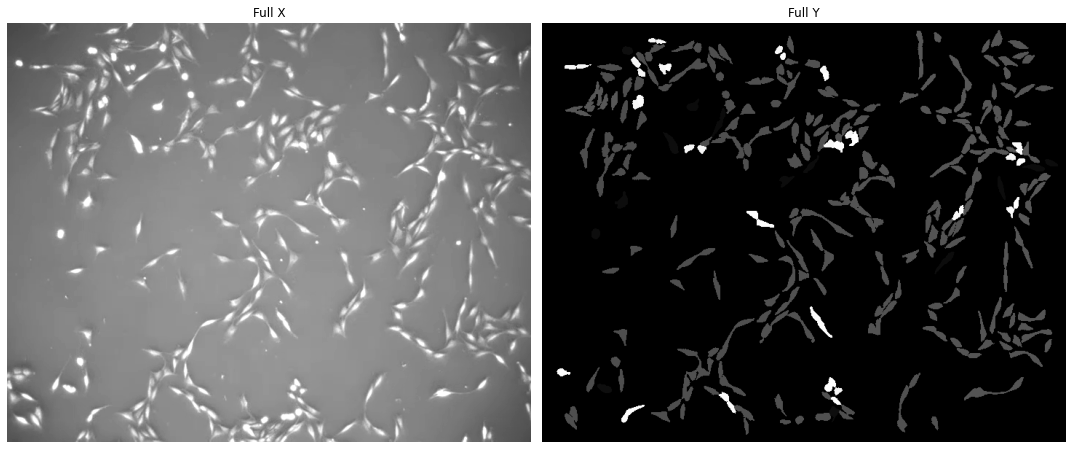

In [ ]:
# remove patchify appendix
index_location = 5692
treasure = ( st_y_patchify_labels[index_location] )[ : -2]

for i in range(len(st_y_images)):
    if (treasure in st_y_images[i]):
        print( extractRhsString(st_x_images[i], "T/") )
        print( extractRhsString(st_y_images[i], "T/") )
        break

# 'i' now contains the location of the images!

array = [plt.imread(st_x_images[i]), plt.imread(st_y_images[i])]
labels = ["Full X", "Full Y"]

display(array, labels)

Clearly, the model is working! Let us now shuffle and see if the images correspond

We can now reshuffle our data and select the first 800

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, x_test, y_train, y_test = train_test_split(
    st_x_patchify_images, st_y_patchify_images, test_size=0.33, random_state=42
)

x_train = x_train[0:800]
x_test = x_test[0:200]
y_train = y_train[0:800]
y_test = y_test[0:200]

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train_labels, x_test_labels, y_train_labels, y_test_labels = train_test_split(
    st_x_patchify_labels, st_y_patchify_labels, test_size=0.33, random_state=42
)

x_train_labels = x_train_labels[0:800]
x_test_labels = x_test_labels[0:200]
y_train_labels = y_train_labels[0:800]
y_test_labels = y_test_labels[0:200]

Index used: 184
Index used: 228
Index used: 732


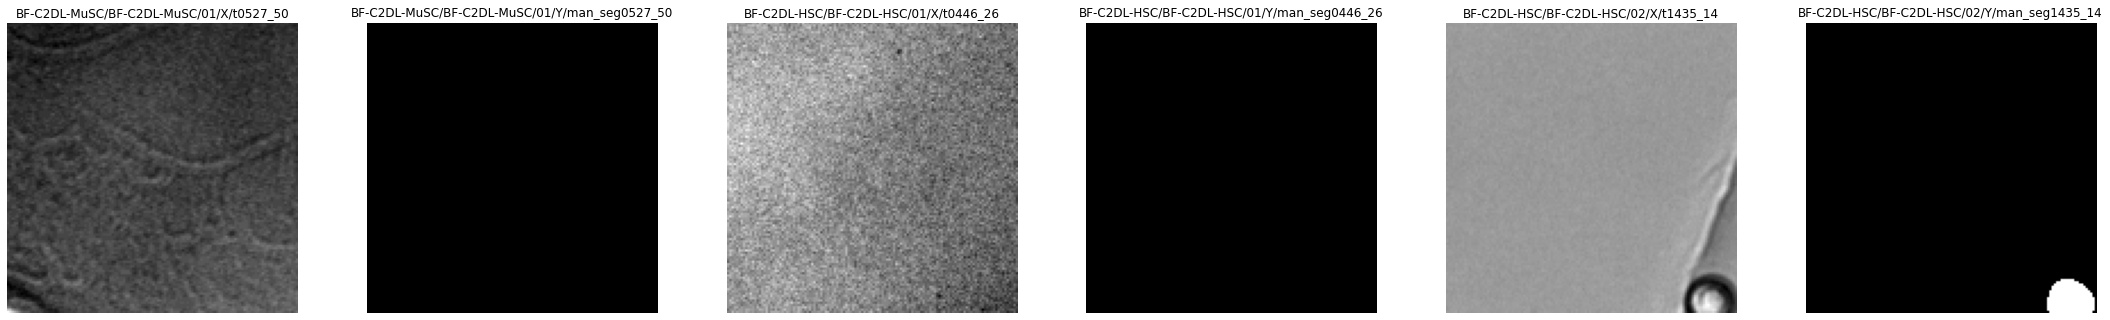

In [ ]:
# verify patches correspond before shuffling:
from random import randint
array, labels = [], []

for i in range(3):
    index = randint(0, len(x_train)-1)
    print("Index used:", index)

    array.append( x_train[index] ) 
    array.append( y_train[index] )
    labels.append( x_train_labels[index] )
    labels.append( y_train_labels[index] )

display(array, labels, figsize=(30, 30))

Let's investigate 732

BF-C2DL-HSC/BF-C2DL-HSC/02/X/t1435.tif
BF-C2DL-HSC/BF-C2DL-HSC/02/Y/man_seg1435.tif


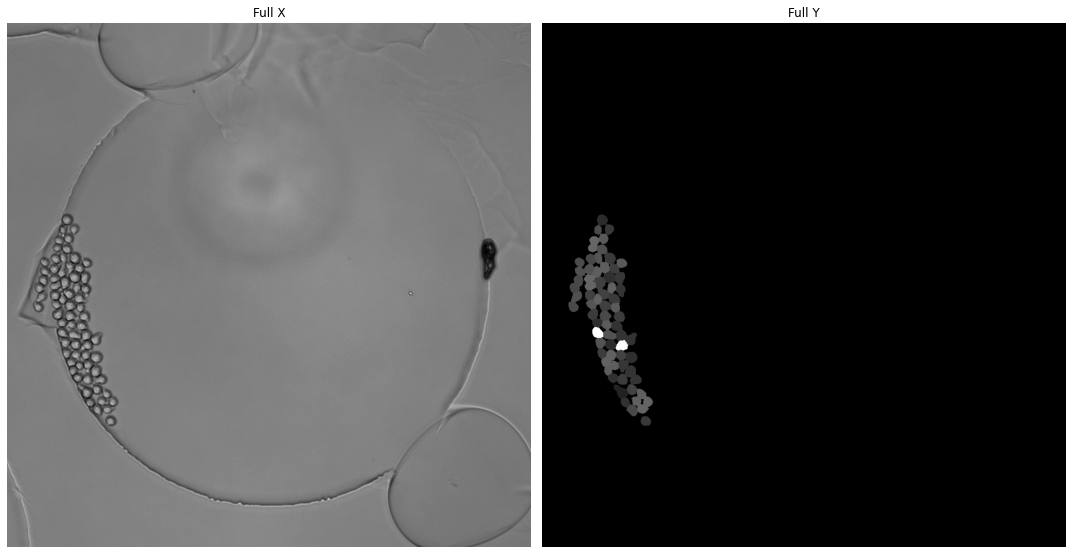

In [ ]:
# remove patchify appendix
index_location = 732
treasure = ( y_train_labels[index_location] )[ : -3]

for i in range(len(st_y_images)):
    if (treasure in st_y_images[i]):
        print( extractRhsString(st_x_images[i], "T/") )
        print( extractRhsString(st_y_images[i], "T/") )
        break

# 'i' now contains the location of the images!

array = [plt.imread(st_x_images[i]), plt.imread(st_y_images[i])]
labels = ["Full X", "Full Y"]

display(array, labels)

## Update Mask Classes from Multiclass to Binary class

In [ ]:
y_train_binary = []

for mask in y_train:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_train_binary.append( temp )

In [ ]:
y_test_binary = []

for mask in y_test:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_test_binary.append( temp )

## Compare a few patches

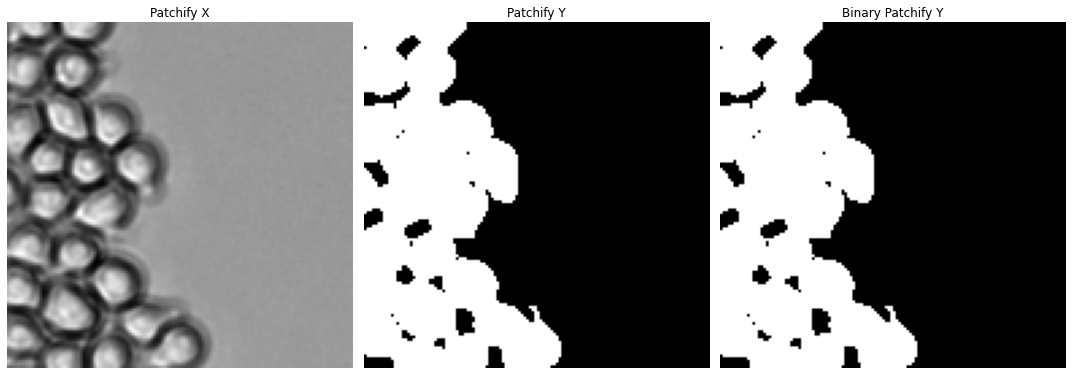

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

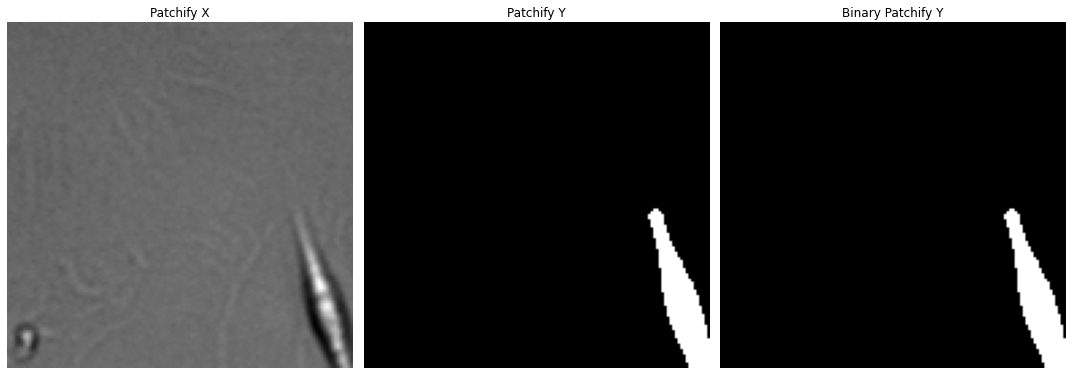

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

## Save Training data for future use

In this section of the notebook, the author will save the images onto Google Drive, such that a future notebook can load the images and use them for training.

This may assist with the RAM Restrictions present on Google Colab, to prevent everything happening in 1 notebook

In [ ]:
directory_list = ["COMP700_Patchify_Images_128_ST", "Training", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_128_ST", "Training", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_128_ST", "Test", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_128_ST", "Test", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

Uncomment and rerun if need be

In [ ]:
training_data_directory

'/content/drive/MyDrive/COMP700_Images/'

In [ ]:
# saveImages(x_train, training_data_directory + "COMP700_Patchify_Images_128_ST/Training/X", "training_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_train_binary, training_data_directory + "COMP700_Patchify_Images_128_ST/Training/Y", "training_mask")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(x_test, training_data_directory + "COMP700_Patchify_Images_128_ST/Test/X", "test_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_test_binary, training_data_directory + "COMP700_Patchify_Images_128_ST/Test/Y", "test_mask")

Images saved successfuly
Images moved successfully


## 256 Patch Size

In [ ]:
scaler = MinMaxScaler()

Recall the table we calculated at the beginning:

(X is training, Y is test)

|   | Proposed Number of Images | Patch Size | Quantity of Patchified Images per Image |Resulting Training Data Quantity | Target Quantity |
|---|---------------------------|------------|----------------------------|---------------------------------|--------|
| A | x = 6, y = 1, total = 7 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 384, y = 64, total = 448 | 500 |
| A | x = 25, y = 6, total = 31 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 400, y = 96, total = 496 | 500 |
| A | x = 100, y = 25, total = 125 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 400, y = 100, total = 500 | 500 |
| B | x = 12, y = 3, total = 15 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 768, y = 192, total = 960 | 1000 |
| B | x = 50, y = 12, total = 62 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 800, y = 192, total = 992 | 1000 |
| B | x = 200, y = 50, total = 250 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 800, y = 200, total = 1000 | 1000 |

From the above, a trend forms. If we desire 1500 images, we can write that as (3 * A), and we choose the row with the corresponding patch size

So, let's say we want to end up with 1000 images of Patchified images, and a patch size of 256.

We need 50 X images and 12 Y images.

But that is a bit too narrow for our dataset... It may mean we would be looking exclusively at some datasets and not others...

Instead, let's generate 10000 patchified images, randomly shuffle them, and select the first 1000 for training!

To get this, we can use all the data from our training set. This is because our x_train only contains 387 images to begin with. We could use 800, but that is missing

We can shuffle the images using ScikitLearn, and then select only part of the cluster for future use

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, _, y_train, _ = train_test_split(
    st_x_images, st_y_images, test_size=0.33, random_state=42
)

In [ ]:
# verify data corresponds:
for i in range(5):
  print(x_train[i], ":::", y_train[i])

/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/02/X/t0066.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/02/Y/man_seg0066.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/02/X/t0821.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/02/Y/man_seg0821.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/t0047.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0047.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-MuSC/BF-C2DL-MuSC/01/X/t0485.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-MuSC/BF-C2DL-MuSC/01/Y/man_seg0485.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/t1350.tif ::: /content/drive/MyDrive/COMP700_Images/COMP7

These cells keep causing the session to crash, so let's try bringing in fewer images

In [ ]:
patch_size = 256
st_x_patchify_images, st_x_patchify_labels = patchifyImages(x_train[0 : 300], patch_size, imageIsMask=False)

print()
print(len(st_x_patchify_images), "images exist")

Patchifying 1/300 images
Patchifying 50/300 images
Patchifying 100/300 images
Patchifying 150/300 images
Patchifying 200/300 images
Patchifying 250/300 images
Patchifying 300/300 images
Patchify process complete!

3309 images exist


In [ ]:
patch_size = 256
st_y_patchify_images, st_y_patchify_labels = patchifyImages(y_train[0 : 300], patch_size, imageIsMask=True)

print()
print(len(st_y_patchify_images), "images exist")

Patchifying 1/300 images
Patchifying 50/300 images
Patchifying 100/300 images
Patchifying 150/300 images
Patchifying 200/300 images
Patchifying 250/300 images
Patchifying 300/300 images
Patchify process complete!

3309 images exist


We can now reshuffle our data and take the first 800

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, x_test, y_train, y_test = train_test_split(
    st_x_patchify_images, st_y_patchify_images, test_size=0.33, random_state=42
)

x_train = x_train[0:800]
x_test = x_test[0:200]
y_train = y_train[0:800]
y_test = y_test[0:200]

## Update Mask Classes from Multiclass to Binary class

In [ ]:
y_train_binary = []

for mask in y_train:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_train_binary.append( temp )

In [ ]:
y_test_binary = []

for mask in y_test:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_test_binary.append( temp )

## Compare a few patches

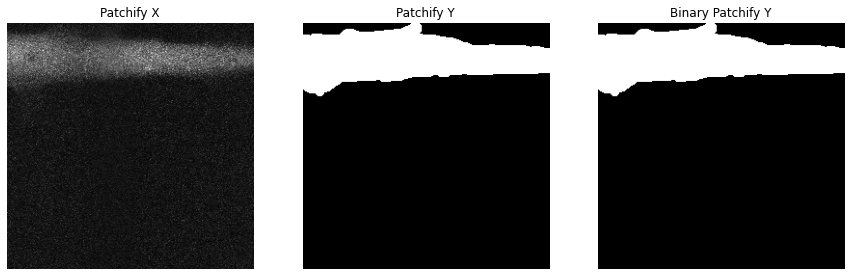

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

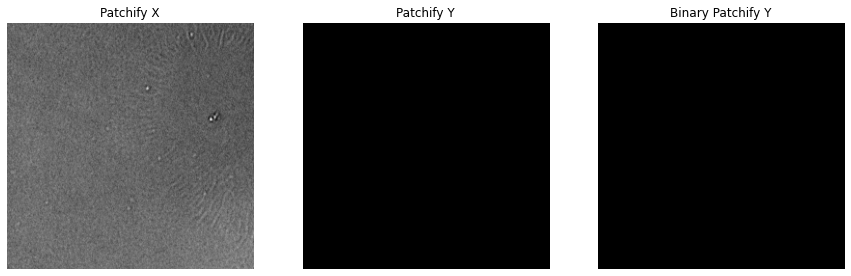

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

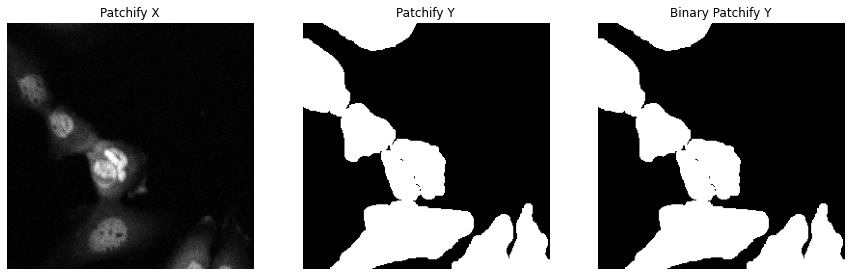

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

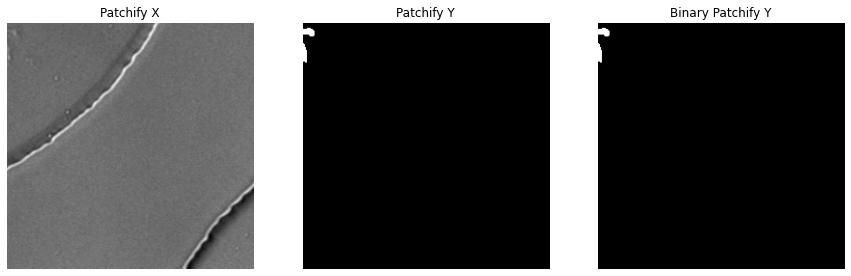

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

## Save Training data for future use

In [ ]:
directory_list = ["COMP700_Patchify_Images_256_ST", "Training", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_256_ST", "Training", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_256_ST", "Test", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_256_ST", "Test", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

In [ ]:
# saveImages(x_train, training_data_directory + "COMP700_Patchify_Images_256_ST/Training/X", "training_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_train_binary, training_data_directory + "COMP700_Patchify_Images_256_ST/Training/Y", "training_mask")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(x_test, training_data_directory + "COMP700_Patchify_Images_256_ST/Test/X", "test_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_test_binary, training_data_directory + "COMP700_Patchify_Images_256_ST/Test/Y", "test_mask")

Images saved successfuly
Images moved successfully


## 512 Patch Size

In [ ]:
scaler = MinMaxScaler()

Recall the table we calculated at the beginning:

(X is training, Y is test)

|   | Proposed Number of Images | Patch Size | Quantity of Patchified Images per Image |Resulting Training Data Quantity | Target Quantity |
|---|---------------------------|------------|----------------------------|---------------------------------|--------|
| A | x = 6, y = 1, total = 7 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 384, y = 64, total = 448 | 500 |
| A | x = 25, y = 6, total = 31 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 400, y = 96, total = 496 | 500 |
| A | x = 100, y = 25, total = 125 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 400, y = 100, total = 500 | 500 |
| B | x = 12, y = 3, total = 15 | 128 | $\lfloor \frac{1036}{128} \rfloor * \lfloor \frac{1036}{128} \rfloor =  8 * 8 = 64$ | x = 768, y = 192, total = 960 | 1000 |
| B | x = 50, y = 12, total = 62 | 256 | $\lfloor \frac{1036}{256} \rfloor * \lfloor \frac{1036}{256} \rfloor =  4 * 4 = 16$ | x = 800, y = 192, total = 992 | 1000 |
| B | x = 200, y = 50, total = 250 | 512 | $\lfloor \frac{1036}{512} \rfloor * \lfloor \frac{1036}{512} \rfloor =  2 * 2 = 4$ | x = 800, y = 200, total = 1000 | 1000 |

From the above, a trend forms. If we desire 1500 images, we can write that as (3 * A), and we choose the row with the corresponding patch size

So, let's say we want to end up with 1000 images of Patchified images, and a patch size of 512.

We need 200 X images and 250 Y images.

But that is a bit too narrow for our dataset... It may mean we would be looking exclusively at some datasets and not others...

Instead, let's generate 10000 patchified images, randomly shuffle them, and select the first 1000 for training!

To get this, we can use all the data from our training set. This is because our x_train only contains 387 images to begin with

We can shuffle the images using ScikitLearn, and then select only part of the cluster for future use

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, _, y_train, _ = train_test_split(
    st_x_images, st_y_images, test_size=0.33, random_state=42
)

In [ ]:
# verify data corresponds:
for i in range(5):
  print(x_train[i], ":::", y_train[i])

/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/02/X/t0066.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/02/Y/man_seg0066.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/02/X/t0821.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/02/Y/man_seg0821.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/t0047.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/Y/man_seg0047.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-MuSC/BF-C2DL-MuSC/01/X/t0485.tif ::: /content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-MuSC/BF-C2DL-MuSC/01/Y/man_seg0485.tif
/content/drive/MyDrive/COMP700_Images/COMP700_Raw_Training_ST/BF-C2DL-HSC/BF-C2DL-HSC/01/X/t1350.tif ::: /content/drive/MyDrive/COMP700_Images/COMP7

In [ ]:
def extractRHS(string, char):
  index = string.rfind(char)
  # print(index)
  return string[index + len(char) : ]
###

errors = []
count = 0
for i in range(len(x_train)):
  if (extractRHS(x_train[i], "/t") != extractRHS(y_train[i], "g")):
    count += 1
    errors.append(i)

print(count, "image(s) do not match")

0 image(s) do not match


These cells keep causing the session to crash, so let's try bringing in fewer images

In [ ]:
patch_size = 512
st_x_patchify_images, st_x_patchify_labels = patchifyImages(x_train[:300], patch_size, imageIsMask=False)

print()
print(len(st_x_patchify_images), "images exist")

Patchifying 1/300 images
Patchifying 50/300 images
Patchifying 100/300 images
Patchifying 150/300 images
Patchifying 200/300 images
Patchifying 250/300 images
Patchifying 300/300 images
Patchify process complete!

665 images exist


In [ ]:
patch_size = 512
st_y_patchify_images, st_x_patchify_labels = patchifyImages(y_train[:300], patch_size, imageIsMask=True)

print()
print(len(st_y_patchify_images), "images exist")

Patchifying 1/300 images
Patchifying 50/300 images
Patchifying 100/300 images
Patchifying 150/300 images
Patchifying 200/300 images
Patchifying 250/300 images
Patchifying 300/300 images
Patchify process complete!

665 images exist


We can now reshuffle our data and take the first 800

In [ ]:
from sklearn.model_selection import train_test_split

# notice how we discard the test sets for now
x_train, x_test, y_train, y_test = train_test_split(
    st_x_patchify_images, st_y_patchify_images, test_size=0.33, random_state=42
)

x_train = x_train[0:800]
x_test = x_test[0:200]
y_train = y_train[0:800]
y_test = y_test[0:200]

## Update Mask Classes from Multiclass to Binary class

In [ ]:
y_train_binary = []

for mask in y_train:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_train_binary.append( temp )

In [ ]:
y_test_binary = []

for mask in y_test:
    temp = mask
    temp[temp > 0.0] = 1.0
    y_test_binary.append( temp )

## Compare a few patches

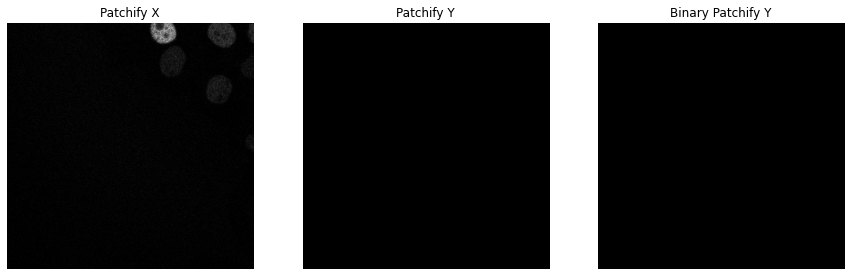

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

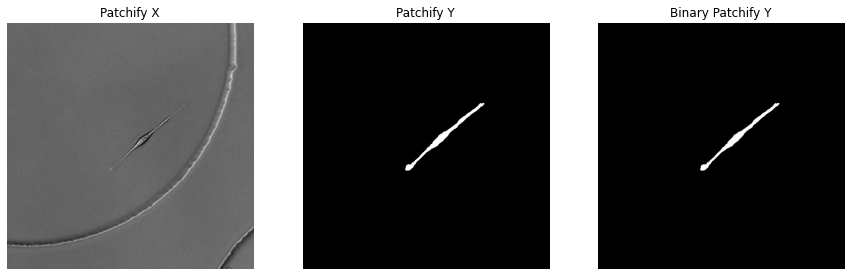

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

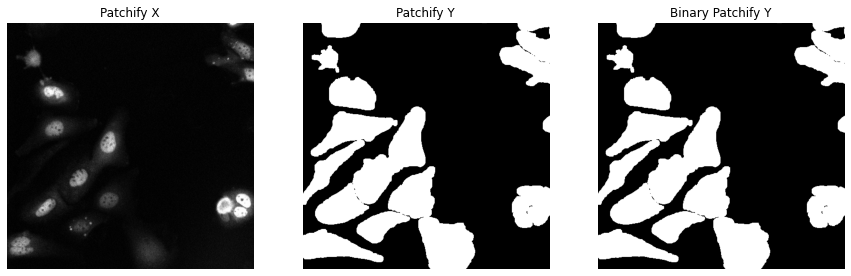

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

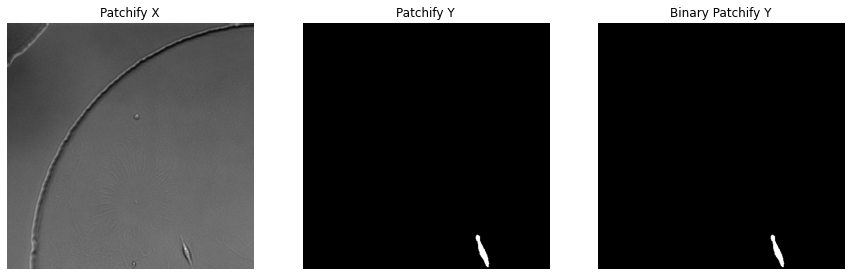

In [ ]:
from random import randint

index = randint(0, len(x_train) - 1)

array = [x_train[index], y_train[index], y_train_binary[index]]
labels = ["Patchify X", "Patchify Y", "Binary Patchify Y"]

display(array, labels)

## Save Training data for future use

In [ ]:
directory_list = ["COMP700_Patchify_Images_512_ST", "Training", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_512_ST", "Training", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_512_ST", "Test", "X"]
tryMakeDirectories(training_data_directory, directory_list)

directory_list = ["COMP700_Patchify_Images_512_ST", "Test", "Y"]
tryMakeDirectories(training_data_directory, directory_list)

In [ ]:
# saveImages(x_train, training_data_directory + "COMP700_Patchify_Images_512_ST/Training/X", "training_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_train_binary, training_data_directory + "COMP700_Patchify_Images_512_ST/Training/Y", "training_mask")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(x_test, training_data_directory + "COMP700_Patchify_Images_512_ST/Test/X", "test_image")

Images saved successfuly
Images moved successfully


In [ ]:
# saveImages(y_test_binary, training_data_directory + "COMP700_Patchify_Images_512_ST/Test/Y", "test_mask")

Images saved successfuly
Images moved successfully
